In [1]:
from models import *
from train import *
from plot import *

In [2]:
# model = Siamese(fc_parameters={'input_size': 64})
model = model_kat = Siamese(conv_block_parameters={
    'ch1': 32, 'ch2': 64,
    'conv1_kernel': 3, 'conv2_kernel': 3,
    'use_max_pool1': True, 'max_pool1_kernel': 2, 'max_pool1_stride': 2
}, fc_parameters=
{
    'input_size': 1024, 'fc': 256, 'out': 10,
    'activation1': nn.ReLU(), 'activation2': nn.Softmax(dim=1),
    'use_batch_norm': False
})

In [3]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)

In [4]:
print(train_input[0:5].shape)

with torch.no_grad():
    pred_leq, (pred_class1, pred_class2) = model(train_input[0:5])
    print(pred_leq)
    print(pred_class1)
    print(pred_class2)

torch.Size([5, 2, 14, 14])
tensor([[0.5501],
        [0.5489],
        [0.5481],
        [0.5462],
        [0.5469]])
tensor([[0.0958, 0.0960, 0.1276, 0.0785, 0.1122, 0.1311, 0.0722, 0.0754, 0.1249,
         0.0864],
        [0.1193, 0.0935, 0.1256, 0.0934, 0.0840, 0.1156, 0.0795, 0.0867, 0.1144,
         0.0880],
        [0.1031, 0.1034, 0.1318, 0.0916, 0.0711, 0.1096, 0.0711, 0.0916, 0.1188,
         0.1079],
        [0.1086, 0.0955, 0.1252, 0.0947, 0.0956, 0.1075, 0.0782, 0.0852, 0.1182,
         0.0914],
        [0.0976, 0.0953, 0.1136, 0.0888, 0.0984, 0.1339, 0.0908, 0.0698, 0.1160,
         0.0958]])
tensor([[0.1240, 0.0896, 0.1319, 0.0973, 0.0784, 0.1242, 0.0784, 0.0831, 0.1054,
         0.0878],
        [0.1051, 0.0934, 0.1202, 0.0979, 0.0968, 0.1060, 0.0913, 0.0806, 0.1136,
         0.0950],
        [0.1082, 0.0904, 0.1122, 0.0873, 0.1002, 0.1461, 0.0639, 0.0948, 0.1198,
         0.0771],
        [0.0938, 0.0791, 0.1308, 0.0877, 0.1002, 0.1203, 0.0925, 0.0791, 0.1142,
        

In [5]:
summary(model, input_size=(1, 2, 14, 14))

Layer (type:depth-idx)                   Output Shape              Param #
Siamese                                  [1, 1]                    --
├─ConvBlock: 1-1                         [1, 64, 4, 4]             --
│    └─Conv2d: 2-1                       [1, 32, 12, 12]           320
│    └─MaxPool2d: 2-2                    [1, 32, 6, 6]             --
│    └─BatchNorm2d: 2-3                  [1, 32, 6, 6]             64
│    └─ReLU: 2-4                         [1, 32, 6, 6]             --
│    └─Conv2d: 2-5                       [1, 64, 4, 4]             18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 4, 4]             128
│    └─ReLU: 2-7                         [1, 64, 4, 4]             --
├─Flatten: 1-2                           [1, 1024]                 --
├─FCBlock: 1-3                           [1, 10]                   512
│    └─Linear: 2-8                       [1, 256]                  262,400
│    └─ReLU: 2-9                         [1, 256]                  --
│  

In [6]:
device = torch.device('cpu') # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start = time.perf_counter()
info_cycle = train_model(model,
                            train_input, train_target, train_classes,
                            nb_epochs=25, mini_batch_size=100,
                            criterion_classes=nn.MSELoss(), criterion_leq=nn.MSELoss(),
                            optimizer= None,
                            weight_loss_classes=0.0, weight_loss_pairs=1.0,
                            freeze_epochs=0,
                            one_hot_classes=True, one_hot_leq=False,
                            verbose=False,
                            test_input=test_input, test_target=test_target, test_classes=test_classes,
                            device=device)
end = time.perf_counter()
print(f'Time: {end - start:.2f}s')

/home/ethan/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Time: 4.19s


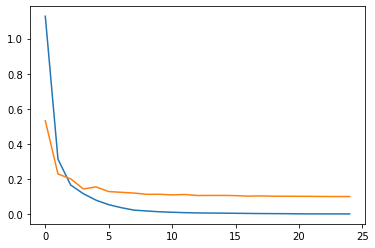

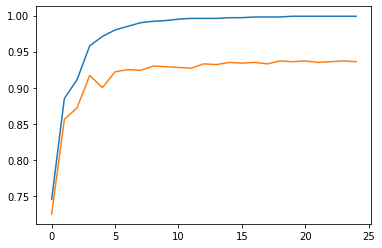

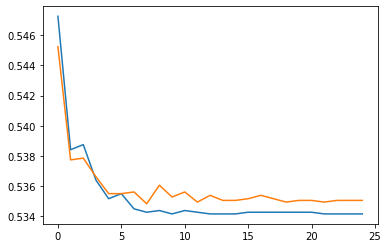

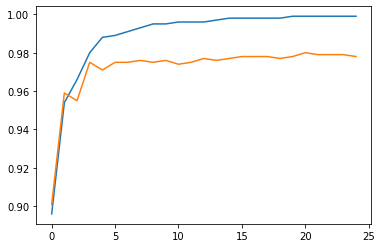

In [7]:
import matplotlib.pyplot as plt

plt.plot(info_cycle['train']['loss'])
plt.plot(info_cycle['test']['loss'])
plt.show()

plt.plot(info_cycle['train']['acc_classes'])
plt.plot(info_cycle['test']['acc_classes'])
plt.show()

plt.plot(info_cycle['train']['acc_leq'])
plt.plot(info_cycle['test']['acc_leq'])
plt.show()

plt.plot(info_cycle['train']['acc_naive'])
plt.plot(info_cycle['test']['acc_naive'])
plt.show()
